[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/seap-udea/multimin/blob/master/examples/multimin_asteroids_application.ipynb)

<p align="left"><img src="https://raw.githubusercontent.com/seap-udea/multimin/master/docs/multimin-logo-white.webp" width="600" /></p>

# Asteroid orbital elements: an application of **multimin**

This notebook goes deeper into the **multimin** module: loading data, building MoGs, and fitting with bounds and multiple components for a particular case, the orbital elements of asteroids.

## Installation

If you're running this in Google Colab or need to install the package, uncomment and run the following cell:

In [1]:
import os
import matplotlib.pyplot as plt
os.makedirs('gallery', exist_ok=True)
try:
    from google.colab import drive
    %pip install -Uq multimin
except ImportError:
    print("Not running in Colab, skipping installation")
    %load_ext autoreload
    %autoreload 2
!mkdir -p gallery/

# Uncomment to install from GitHub (development version)
# !pip install git+https://github.com/seap-udea/MultiMin.git

Not running in Colab, skipping installation


## Load the package

Import **multimin** and other required libraries:

In [2]:
import pandas as pd
import numpy as np
import multimin as mn
import warnings
%matplotlib inline

warnings.filterwarnings("ignore")

figprefix="asteroids"

Welcome to MultiMin v0.10.0. ¡Al infinito y más allá!


## Asteroid data

**multimin** was originally developed to solve the problem of describing the distribution of asteroids in the space of orbital elements. This is a true scientific application of the package that illustrate the power of the methods and the versatility of the numerical methods provided by the package.

Load the dataset (e.g. orbital elements):

In [3]:
# NEA Data
df_neas=pd.read_json(mn.Util.get_data("nea_data.json.gz"))

# Let's filter 10000 asteroids
df_neas=df_neas.sample(10000)

# Let's select the columns we want to fit
df_neas["q"]=df_neas["a"]*(1-df_neas["e"])
data_neas=np.array(df_neas[["q","e","i","Node","Peri","M"]])

Let's see the data:

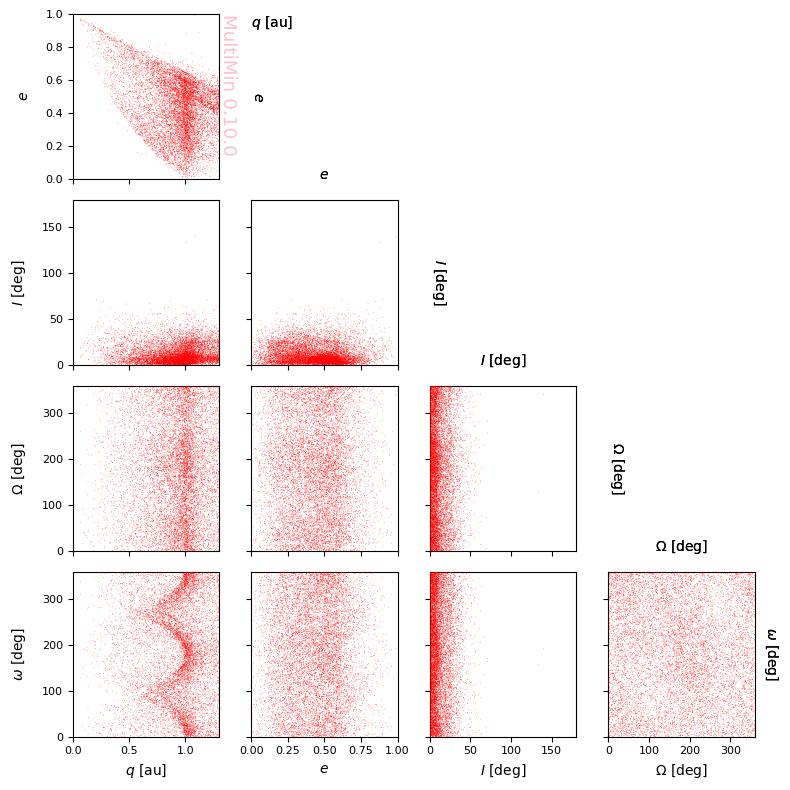

In [4]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
    i=dict(label=r"$I$ [deg]",range=[0.0,180.0]),
    W=dict(label=r"$\Omega$ [deg]",range=[0,360]),
    w=dict(label=r"$\omega$ [deg]",range=[0,360]),
)
G=mn.MultiPlot(properties,figsize=2)

sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas.png')


Or a colormesh:

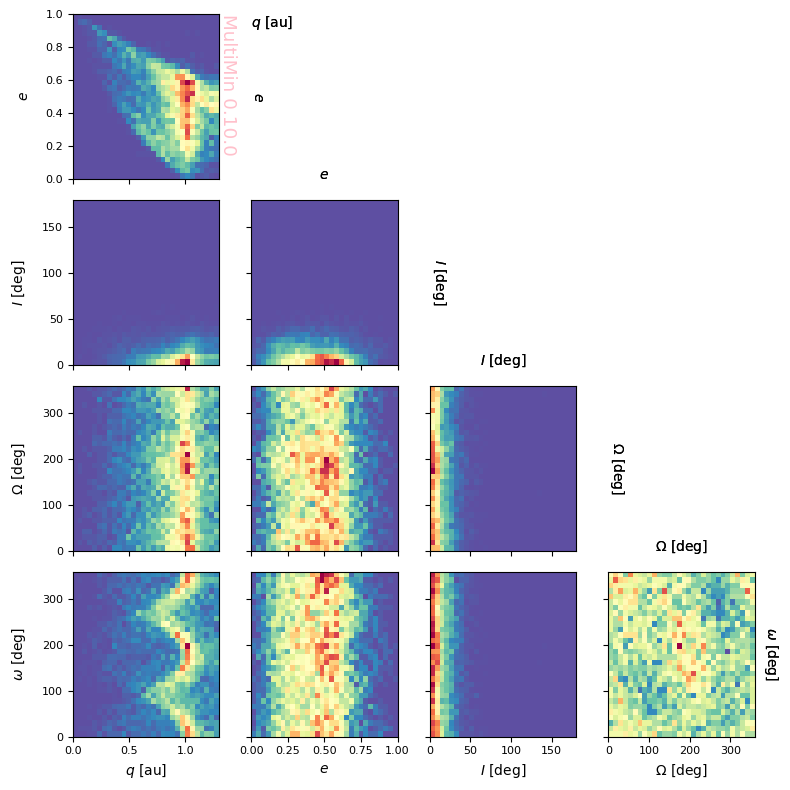

In [5]:
G=mn.MultiPlot(properties,figsize=2)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(data_neas,**hargs)
plt.savefig(f'gallery/{figprefix}_data_neas_hist.png')

### Non-trivially correlated properties

The only elements with a non-trivial distribution are $q, e, I$. Let's study the distribution, for instance, of the $q$ and $e$. For this purpose we need to create a subset:

In [6]:
data_neas_qe=np.array(df_neas[["q","e"]])

And plot it:

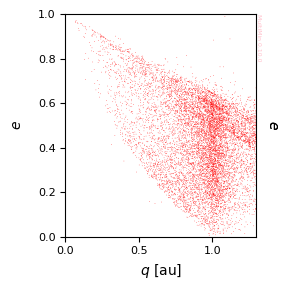

In [7]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)

G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter=G.sample_scatter(data_neas_qe,**sargs)

plt.savefig(f'gallery/{figprefix}_data_neas_qe.png')

Now we will proceed to fit the data against a singled truncated distribution:

In [8]:
t = mn.Util.el_time(0)
F_qe_1 = mn.FitMoG(data=data_neas_qe, ngauss=1, domain=[[0,1.3], [0, 1]])
F_qe_1.fit_data(progress=False)
t = mn.Util.el_time()
print(f"-log(L)/N = {F_qe_1.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.30674628429764905
Elapsed time since last call: 132.793 ms
-log(L)/N = -0.527594247509747


And check the fit result:

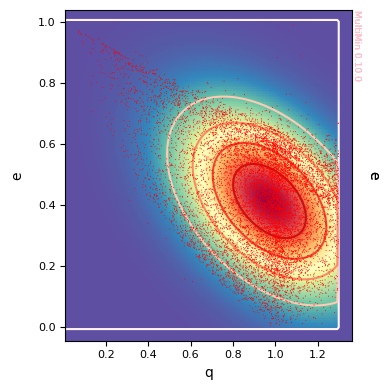

In [9]:
# properties: list of names or dict like MultiPlot (e.g. dict(q=dict(label=r"$q$", range=None), ...))
properties=["q","e"]
pargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
cargs=dict()
G=F_qe_1.plot_fit(properties=properties,pargs=hargs,sargs=sargs,cargs=cargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_1gauss.png')


In [10]:
F_qe_1.mog.tabulate()

,w,mu_1,mu_2,sigma_1,sigma_2,rho_12
component,,,,,,
1,1.0,0.973308,0.413463,0.271734,0.191704,-0.450451


We can do it better increasing the number of normals:

In [11]:
t = mn.Util.el_time(0)
F = mn.FitMoG(data=data_neas_qe, ngauss=5, domain=[[0,1.3], [0, 1]])
F.fit_data(advance=50)
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(data_neas_qe)}")

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 2
Number of dimensions: 10
Number of samples: 10000
Domain: [[0, 1.3], [0, 1]]
Log-likelihood per point (-log L/N): 0.2466289521715922
Iterations:
Iter 0:
	Vars: [-1.4, -1.3, -1.3, -1.3, -1.5, 0.46, 0.14, 0.81, 0.32, 0.96, 0.45, 1, 0.55, 1.2, 0.72, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, -4.5, -4.7, 0.65, 0.65, 0.73, 0.43, 1.1]
	LogL/N: 2.1510749375258404


Iter 50:
	Vars: [-2.2, -1.1, -0.84, -0.75, -2.1, 0.77, 0.23, 0.79, 0.42, 1, 0.36, 1.1, 0.53, 1.2, 0.4, -4.4, -4.7, -3.6, -4, -5, -4.1, -3.3, -4.2, -3.9, -4.3, -1.8, -1.9, -0.82, -3.4, 0.51]
	LogL/N: -0.699562664285539


Iter 100:
	Vars: [-2.2, -1.1, -0.82, -0.59, -2.4, 0.75, 0.23, 0.82, 0.42, 1, 0.35, 1.1, 0.51, 1.3, 0.33, -4.1, -4.5, -3.7, -4.3, -5, -4.2, -3.1, -4.1, -3.9, -4.2, -2.7, -1.5, -0.16, -3.5, 0.3]
	LogL/N: -0.7085074211055303


Iter 150:
	Vars: [-2.2, -1, -0.72, -0.68, -2.4, 0.74, 0.23, 0.82, 0.42, 1, 0.36, 1.1, 0.51, 1.3, 0.36, -4.1, -4.4, -3.7, -4.2, -4.9, -4.2, -3.1, -4.1, -3.9, -4.2, -3.1, -1.6, -0.35, -3.6, 0.27]
	LogL/N: -0.7097981661205346


Iter 200:
	Vars: [-2.2, -0.98, -0.72, -0.65, -2.5, 0.74, 0.23, 0.83, 0.39, 1, 0.37, 1.1, 0.51, 1.3, 0.38, -4, -4.4, -3.7, -4.1, -4.9, -4.2, -3.1, -4.1, -4, -4.3, -3.4, -1.8, -0.32, -3.6, 0.27]
	LogL/N: -0.710273290381115


Iter 250:
	Vars: [-2.2, -0.96, -0.75, -0.64, -2.5, 0.74, 0.23, 0.84, 0.39, 1, 0.37, 1.1, 0.52, 1.3, 0.38, -4, -4.4, -3.7, -4.1, -5, -4.2, -3.2, -4.1, -4, -4.3, -3.4, -1.9, -0.3, -3.5, 0.29]
	LogL/N: -0.7103359574157586


Iter 300:
	Vars: [-2.2, -0.96, -0.74, -0.64, -2.5, 0.74, 0.23, 0.84, 0.39, 1, 0.37, 1.1, 0.52, 1.3, 0.38, -4, -4.4, -3.7, -4.1, -5, -4.2, -3.2, -4.1, -4, -4.3, -3.4, -1.8, -0.31, -3.5, 0.31]
	LogL/N: -0.7103406163643904


Iter 350:
	Vars: [-2.2, -0.98, -0.63, -0.56, -2.7, 0.73, 0.23, 0.83, 0.4, 1, 0.36, 1.1, 0.52, 1.3, 0.38, -4.1, -4.4, -3.7, -4.1, -4.9, -4.2, -3.2, -4.1, -4.3, -4.3, -3.4, -1.7, -0.25, -3.5, 0.7]
	LogL/N: -0.7104544360803955


Iter 400:
	Vars: [-2.2, -0.94, -0.53, -0.59, -2.9, 0.74, 0.23, 0.83, 0.4, 1, 0.36, 1.1, 0.52, 1.3, 0.4, -4.1, -4.4, -3.7, -4.1, -4.9, -4.2, -3.2, -4.1, -4.7, -4.2, -3.3, -1.8, -0.25, -3.5, 1.1]
	LogL/N: -0.7108463046966145


Iter 445:
	Vars: [-2.2, -0.95, -0.51, -0.56, -3, 0.74, 0.23, 0.83, 0.39, 1, 0.36, 1.1, 0.52, 1.3, 0.41, -4.1, -4.4, -3.7, -4.1, -4.9, -4.2, -3.2, -4.1, -4.7, -4.2, -3.3, -1.8, -0.26, -3.5, 1.2]
	LogL/N: -0.7108855976980456
Elapsed time since last call: 21.932 s
-log(L)/N = -0.7108855976980456


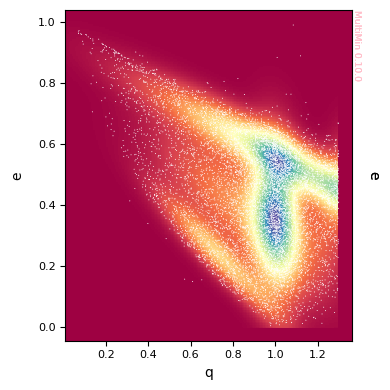

In [12]:
properties=["q","e"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='w')
cargs=dict(levels=100)
pargs=dict(cmap='Spectral')
G=F.plot_fit(
    properties=properties,
    pargs=pargs,
    #hargs=hargs,
    sargs=sargs,
    #cargs=cargs,
    figsize=4
)
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss.png')

Another way of comparing is to generate a sample with the fitted distribution and compare it with the original one:

In [13]:
neas_sample = F.mog.rvs(len(data_neas_qe))

And plot it:

Text(0.5, 1.0, 'Original data')

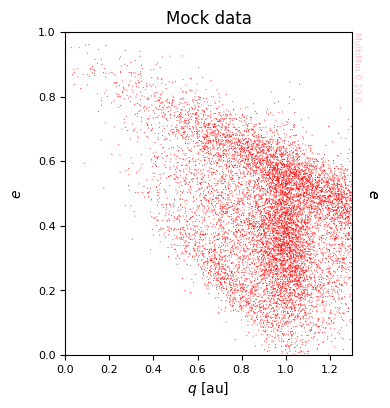

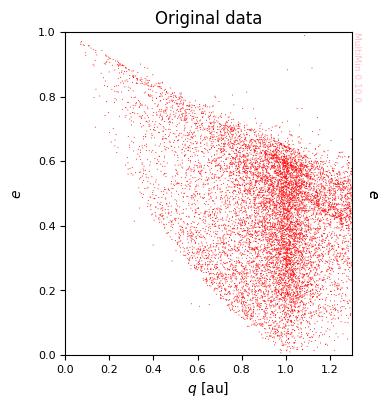

In [14]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
# Mock data
G = mn.MultiPlot(properties,figsize=4)
G.sample_scatter(neas_sample,**sargs)
G.axs[0][0].set_title("Mock data")
plt.savefig(f'gallery/{figprefix}_fit_result_qe_5gauss_sample.png')
# True data
G=mn.MultiPlot(properties,figsize=4)
scatter=G.sample_scatter(data_neas_qe,**sargs)
G.axs[0][0].set_title("Original data")


Let's see the fit function:

In [15]:
properties=dict(
    q=dict(label=r"$q$ [au]",range=[0.0,1.3]),
    e=dict(label=r"$e$",range=[0.0,1.0]),
)
table = F.mog.tabulate(properties=properties)
table

,w,mu_q,mu_e,sigma_q,sigma_e,rho_qe
component,,,,,,
3,0.320747,1.003043,0.364485,0.074994,0.150526,-0.127945
4,0.311306,1.115342,0.521451,0.400915,0.156153,-0.941662
2,0.239578,0.832012,0.393801,0.240615,0.164667,-0.725419
1,0.088050,0.736744,0.232486,0.169869,0.123236,-0.932187
5,0.040319,1.288313,0.409979,0.088553,0.145315,0.519319


In [16]:
function, mog = F.mog.get_function(properties=properties)

import numpy as np
from multimin import Util

def mog(X):

    a = [0.0, 0.0]
    b = [1.3, 1.0]

    mu1_q = 0.736744
    mu1_e = 0.232486
    mu1 = [mu1_q, mu1_e]
    Sigma1 = [[0.028855, -0.019514], [-0.019514, 0.015187]]
    Z1 = 0.970379
    n1 = Util.tnmd(X, mu1, Sigma1, a, b, Z=Z1)

    mu2_q = 0.832012
    mu2_e = 0.393801
    mu2 = [mu2_q, mu2_e]
    Sigma2 = [[0.057896, -0.028742], [-0.028742, 0.027115]]
    Z2 = 0.96967
    n2 = Util.tnmd(X, mu2, Sigma2, a, b, Z=Z2)

    mu3_q = 1.003043
    mu3_e = 0.364485
    mu3 = [mu3_q, mu3_e]
    Sigma3 = [[0.005624, -0.001444], [-0.001444, 0.022658]]
    Z3 = 0.992221
    n3 = Util.tnmd(X, mu3, Sigma3, a, b, Z=Z3)

    mu4_q = 1.115342
    mu4_e = 0.521451
    mu4 = [mu4_q, mu4_e]
    Sigma4 = [[0.160733, -0.058952], [-0.058952, 0.024384]]
    Z4 = 0.674549
    n4 = Util.tnmd(X, mu4, Sigma4, a, b, Z=Z4)

    mu5_q = 1.288313
    mu5_e = 0.409979
    mu5 = [mu5_q, mu5_e]
    Sigma5 = [[0.007842, 0.006683], [0.006683, 0.021117]]
    Z5

### Fitting other pair of properties

Fitting $q$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1.3], [0, 180]]
Log-likelihood per point (-log L/N): 133.38527737557084
-log(L)/N = 3.4851935636206077


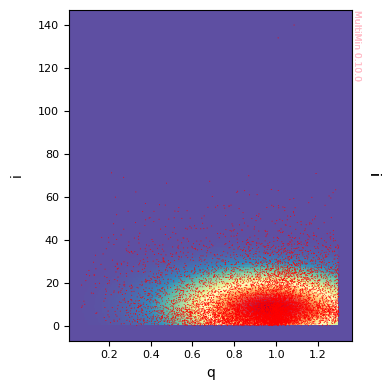

In [17]:
data_neas_qi=np.array(df_neas[["q","i"]])
F_qi_1 = mn.FitMoG(data=data_neas_qi, ngauss=1, domain=[[0,1.3], [0, 180]])
F_qi_1.fit_data(progress=False)
print(f"-log(L)/N = {F_qi_1.solution.fun/len(data_neas_qi)}")

properties=["q","i"]
hargs=dict(bins=30,cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
pargs=dict(cmap='YlGn')
G=F_qi_1.plot_fit(properties=properties,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_qi_1gauss.png')

Fitting $e$ and $I$:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 2
Number of dimensions: 2
Number of samples: 10000
Domain: [[0, 1], [0, 180]]
Log-likelihood per point (-log L/N): 136.0957554986913
-log(L)/N = 3.3108225361998107


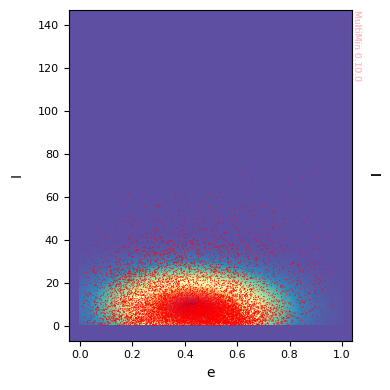

In [18]:
data_neas_ei=np.array(df_neas[["e","i"]])
F_ei_1 = mn.FitMoG(data=data_neas_ei, ngauss=1, domain=[[0,1], [0, 180]])
F_ei_1.fit_data(progress=False)
print(f"-log(L)/N = {F_ei_1.solution.fun/len(data_neas_ei)}")

properties=["e","I"]
sargs=dict(s=0.5,edgecolor='None',color='r')
G=F_ei_1.plot_fit(properties=properties,sargs=sargs,figsize=4)
plt.savefig(f'gallery/{figprefix}_fit_result_ei_1gauss.png')

### Fitting three variables: $q, e, I$

Let's extract first the data:

In [19]:
data_neas_qei = np.array(df_neas[["q","e","i"]])

Let's plot the original data:

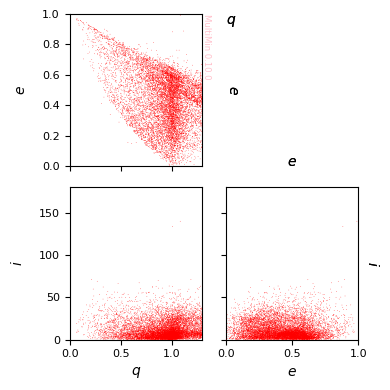

In [20]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

G = mn.MultiPlot(properties, figsize=2)
sargs = dict(s=0.2, edgecolor='None', color='r')
scatter = G.sample_scatter(data_neas_qei, **sargs)
plt.savefig(f'gallery/{figprefix}_data_neas_qei.png')


Now let's try to fit this data using truncated multivariate distribution:

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 146.31299826772698


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -1.4963954200207306


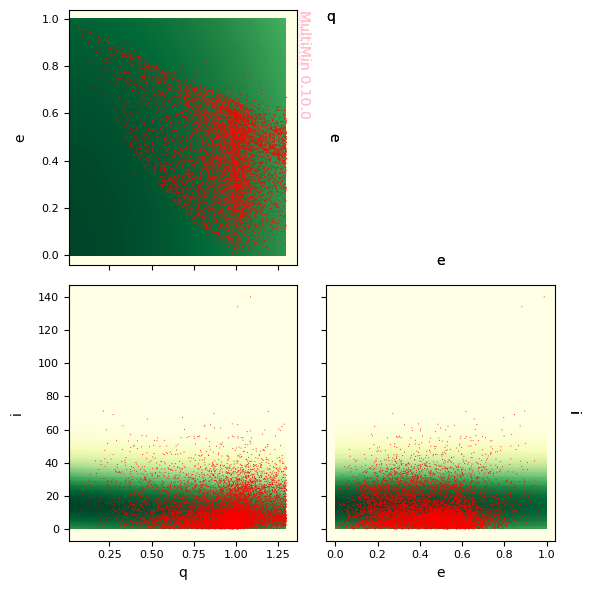

In [21]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    sargs=sargs,
    pargs=pargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_simple.png')

As you see, without information the fit is not too successful. We will try a different approach.

**Initial parameters from partial fits.** The 1-Gaussian fit in (q,e,i) often misses the q–e correlation when started from generic initial values. We use the three 2D fits (F_qe_1, F_qi_1, F_ei_1) to build initial means, sigmas, and correlations for the full 3D fit: each mean/sigma is averaged over the two partial fits that contain that variable; each correlation comes from the single partial fit that contains that pair.

In [22]:
# Initial (mus, sigmas, rhos) from partial fits F_qe_1, F_qi_1, F_ei_1 (vars: 0=q, 1=e, 2=i)
mu_q = (F_qe_1.mog.mus[0, 0] + F_qi_1.mog.mus[0, 0]) / 2
mu_e = (F_qe_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 0]) / 2
mu_i = (F_qi_1.mog.mus[0, 1] + F_ei_1.mog.mus[0, 1]) / 2
sigma_q = (F_qe_1.mog.sigmas[0, 0] + F_qi_1.mog.sigmas[0, 0]) / 2
sigma_e = (F_qe_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 0]) / 2
sigma_i = (F_qi_1.mog.sigmas[0, 1] + F_ei_1.mog.sigmas[0, 1]) / 2
rho_qe = float(F_qe_1.mog.rhos[0, 0])
rho_qi = float(F_qi_1.mog.rhos[0, 0])
rho_ei = float(F_ei_1.mog.rhos[0, 0])

fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=1, domain=[[0, 1.3], [0, 1.0], [0, 180]])
fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)
fit_qei.set_bounds(boundsm=((0.8, 1.2), (0.0, 1.0), (0.0, 15.0)))
fit_qei.fit_data(progress="tqdm", normalize=True)
print(f"-log(L)/N = {fit_qei.solution.fun/len(data_neas_qei)}")

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Domain: [[0, 1.3], [0, 1.0], [0, 180]]
Log-likelihood per point (-log L/N): 146.312997827789


Minimizing: 0it [00:00, ?it/s]

-log(L)/N = -2.3600897280082154


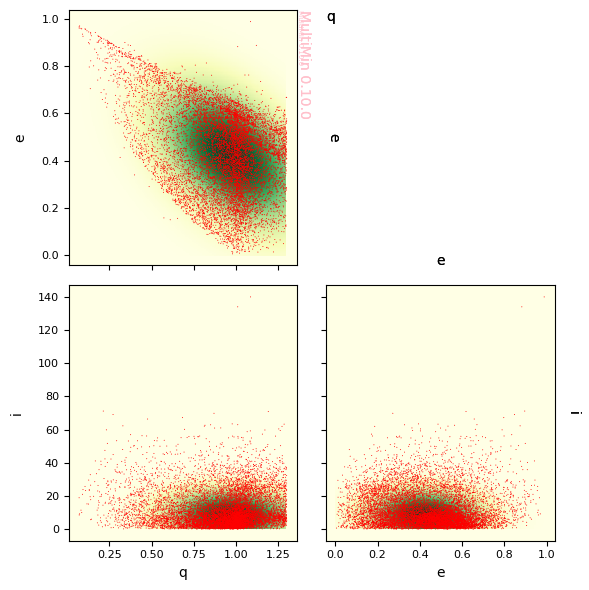

In [23]:
properties=["q","e","i"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.5,edgecolor='None',color='r')
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_1gauss_feed.png')

Much better!

Let's try with more gaussians:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Domain: [[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]]
Log-likelihood per point (-log L/N): 337.150559405795


Minimizing: 0it [00:00, ?it/s]

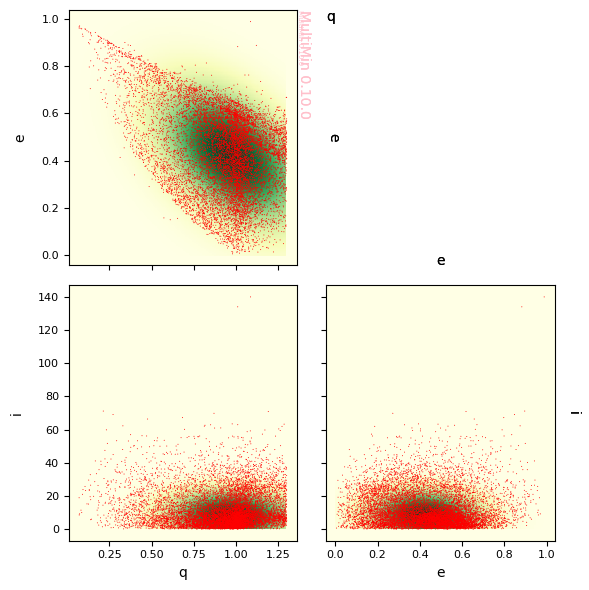

In [24]:
fit_qei = mn.FitMoG(data=data_neas_qei, ngauss=5, domain=[[0.0, 1.3], [0.0, 1.0], [0.0, 180.0]])

fit_qei.set_initial_params(
    mus=[mu_q, mu_e, mu_i],
    sigmas=[sigma_q, sigma_e, sigma_i],
    rhos=[rho_qe, rho_qi, rho_ei],
)

fit_qei.fit_data(progress="tqdm")
G=fit_qei.plot_fit(
    properties=properties,
    pargs=pargs,
    sargs=sargs,
    figsize=3
)
plt.savefig(f'gallery/{figprefix}_fit_result_qei_ngauss.png')

The problem is that the fit is not converging to a good representation of the distribution.

### Transforming data

Orbital elements such as $q$, $e$, and $i$ live in **finite intervals** (e.g. $q \in [0, q_{\max}]$, $e \in [0, 1)$, $i \in [0, \pi]$), while the MoG is defined on the whole real line. To fit a normal mixture on unbounded variables we first map each bounded variable to an unbounded one via a **logistic-type (log-odds) transformation** (see e.g. the *manuscript-neoflux* formalism).

For a variable $x \in (0, x_{\max})$, define the **unbound** variable:

$$u = \log\left(\frac{x/x_{\max}}{1 - x/x_{\max}}\right)$$

so that $u \in (-\infty, +\infty)$. The inverse map is:

$$x = \frac{x_{\max}}{1 + \exp(-u)}$$

In the notebook we use this with $q_{\max}=1.35$ au, $e_{\max}=1$, $i_{\max}=\pi$ to obtain unbound variables $(Q, C, I)$. Fitting the MoG in $(Q, C, I)$ and then transforming back preserves normalization and often improves conditioning; the same transformation is used in the manuscript for the NEO flux formalism.

Transform variables to an unbounded scale for fitting (e.g. with `Util.t_if` / `f2u`):

In [25]:
scales=[1.35,1.00,180.0]
udata=np.zeros_like(data_neas_qei)
for i in range(len(data_neas_qei)):
    udata[i]=mn.Util.t_if(data_neas_qei[i],scales,mn.Util.f2u)

Visualize the data with **MultiPlot** (scatter on pairwise panels):

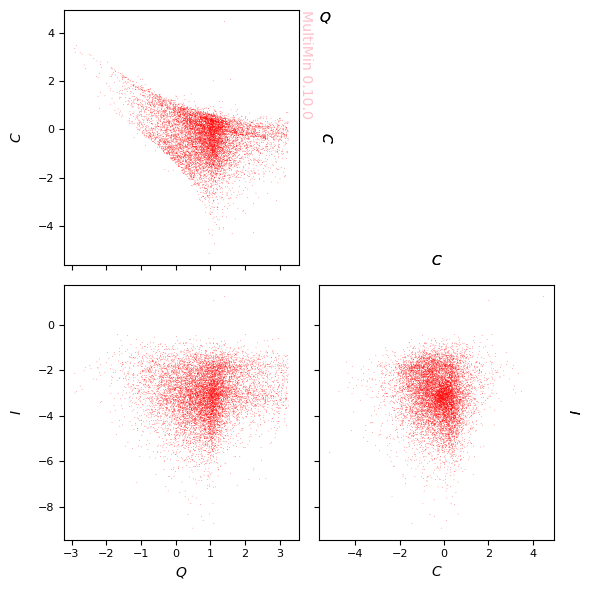

In [26]:
properties=dict(
    Q=dict(label=r"$Q$",range=None),
    E=dict(label=r"$C$",range=None),
    I=dict(label=r"$I$",range=None),
)
G=mn.MultiPlot(properties,figsize=3)

sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

plt.savefig('gallery/indepth_data_scatter_QCI.png')


The same idea (initial parameters from partial fits) can be reused for multi-component fits below.

You can also show 2D histograms on the panels:

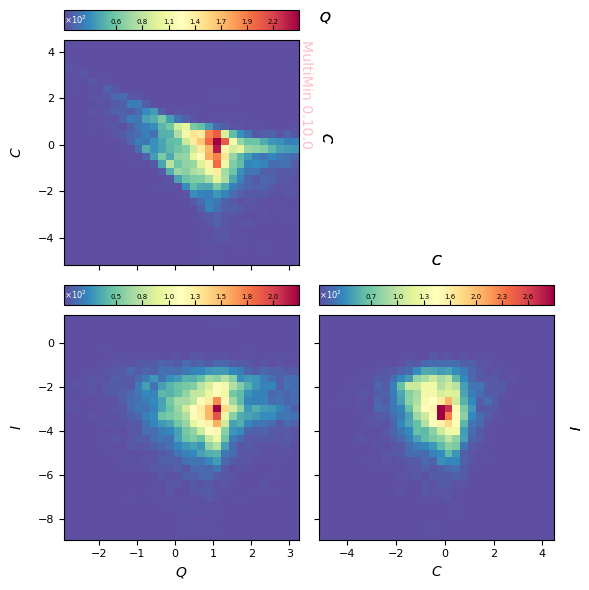

In [27]:
G=mn.MultiPlot(properties,figsize=3)
hargs=dict(bins=30,cmap='Spectral_r')
hist=G.sample_hist(udata,colorbar=True,**hargs)

plt.savefig('gallery/multimin_indepth_2.png')


Create the fitter (e.g. one Gaussian, three variables):

In [28]:
F=mn.FitMoG(data=udata, ngauss=1)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.055958465015495


The fitter holds an initial MoG that will be optimized:

In [29]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.5, 0.5, 0.5]]
    Standard deviations (σ): [[1.0000000000000002, 1.0000000000000002, 1.0000000000000002]]
    Correlation coefficients (ρ): [[0.5, 0.5, 0.5]]

    Covariant matrices (Σ): 
        [[[1.0000000000000004, 0.5000000000000002, 0.5000000000000002], [0.5000000000000002, 1.0000000000000004, 0.5000000000000002], [0.5000000000000002, 0.5000000000000002, 1.0000000000000004]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000004, 0.5000000000000002, 0.5000000000000002, 1.0000000000000004, 0.5000000000000002, 1.0000000000000004]
        With std. and correlations (10):
            [p1,μ1_1,μ1_2,μ1_3,σ1_1,σ1_2,σ1_3,ρ1_12,ρ1_13,ρ1_23]
            [1.0, 0.5, 0.5, 0.5, 1.0000000000000002, 1.0000000000000002, 1.000

Run the minimization:

In [30]:
t = mn.Util.el_time(0)
F.fit_data(verbose=False,progress="tqdm")
t = mn.Util.el_time()
print(f"-log(L)/N = {F.solution.fun/len(udata)}")

Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 147.215 ms
-log(L)/N = 3.99934231884341


Inspect the fitted MoG:

In [31]:
print(F.mog)

Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8545842614010013, -0.32273841924376045, -3.071877578571727]]
    Standard deviations (σ): [[0.8646071654534286, 0.8775045121806425, 1.0838162637694735]]
    Correlation coefficients (ρ): [[-0.3313424218697353, 0.03809374727462034, -0.0683251149623122]]

    Covariant matrices (Σ): 
        [[[0.7475455505534125, -0.2513883983809437, 0.035696709948431854], [-0.2513883983809437, 0.7700141688973874, -0.06498085078003207], [0.035696709948431854, -0.06498085078003207, 1.174657693611221]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8545842614010013, -0.32273841924376045, -3.071877578571727, 0.7475455505534125, -0.2513883983809437, 0.035696709948431854, 0.7700141688973874, -0.06498085078003207, 1.174657693611221]
        With std. and correla

Plot the fit result (fitted sample + data scatter):

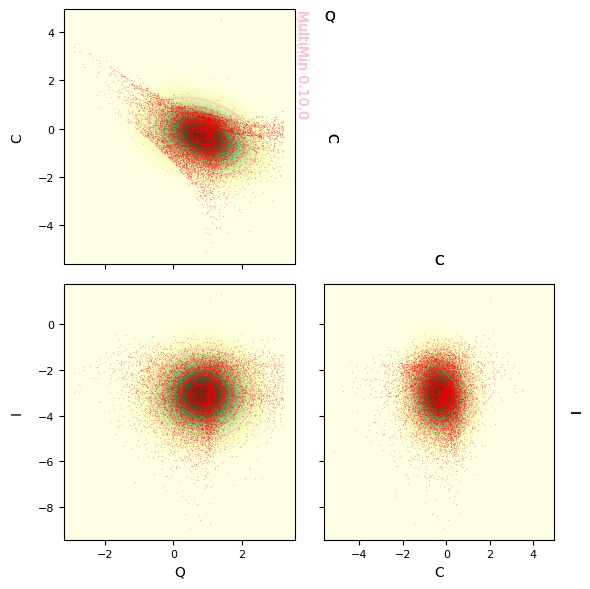

In [32]:
properties=["Q","C","I"]
pargs=dict(cmap='YlGn')
sargs=dict(s=0.2,edgecolor='None',color='r')
cargs=dict()
G=F.plot_fit(properties=properties,sargs=sargs,cargs=cargs,pargs=pargs,figsize=3)

plt.savefig(f'gallery/{figprefix}_indepth_fit_result_QCI.png')


Fitting can be time-consuming; you can save the result for later use:

In [33]:
F.save_fit(f"gallery/{figprefix}_fit-single.pkl",useprefix=False)

Load a previously saved fit (here or in another notebook):

In [34]:
F=mn.FitMoG(f"gallery/{figprefix}_fit-single.pkl")
print(F.mog)

Loading a FitMoG object.
Number of gaussians: 1
Number of variables: 3
Number of dimensions: 3
Number of samples: 10000
Log-likelihood per point (-log L/N): 3.99934231884341
Composition of ngauss = 1 gaussian multivariates of nvars = 3 random variables:
    Weights: [1.0]
    Number of variables: 3
    Averages (μ): [[0.8545842614010013, -0.32273841924376045, -3.071877578571727]]
    Standard deviations (σ): [[0.8646071654534286, 0.8775045121806425, 1.0838162637694735]]
    Correlation coefficients (ρ): [[-0.3313424218697353, 0.03809374727462034, -0.0683251149623122]]

    Covariant matrices (Σ): 
        [[[0.7475455505534125, -0.2513883983809437, 0.035696709948431854], [-0.2513883983809437, 0.7700141688973874, -0.06498085078003207], [0.035696709948431854, -0.06498085078003207, 1.174657693611221]]]
    Flatten parameters: 
        With covariance matrix (10):
            [p1,μ1_1,μ1_2,μ1_3,Σ1_11,Σ1_12,Σ1_13,Σ1_22,Σ1_23,Σ1_33]
            [1.0, 0.8545842614010013, -0.32273841924376045,

Fit with two Gaussian components for a better likelihood:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.055958465015495


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 952.739 ms
-log(L)/N = 3.904331288918072
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.26414622128156257, 0.7358537787184374]
    Number of variables: 3
    Averages (μ): [[0.42926824657736307, 0.48236324675613523, -3.4909341290471936], [0.9926445742589913, -0.5956047611227698, -2.930526971942813]]
    Standard deviations (σ): [[0.8835849544618493, 0.5867390672814725, 1.199773672904918], [0.8068375046491558, 0.7824222690798189, 0.9981779859460399]]
    Correlation coefficients (ρ): [[-0.8282698046908149, -0.35370566903050393, 0.32994525869709923], [-0.04260405039442117, 0.12237079394904771, -0.01719824443360196]]

    Covariant matrices (Σ): 
        [[[0.7807223717513482, -0.4294030722475339, -0.3749640751734709], [-0.4294030722475339, 0.3442627330743323, 0.23226631294656397], [-0.3749640751734709, 0.23226631294656397, 1.4394568661957572]], [[0.6509867589084766, -0.026895410051583444, 0.09855345248772125],

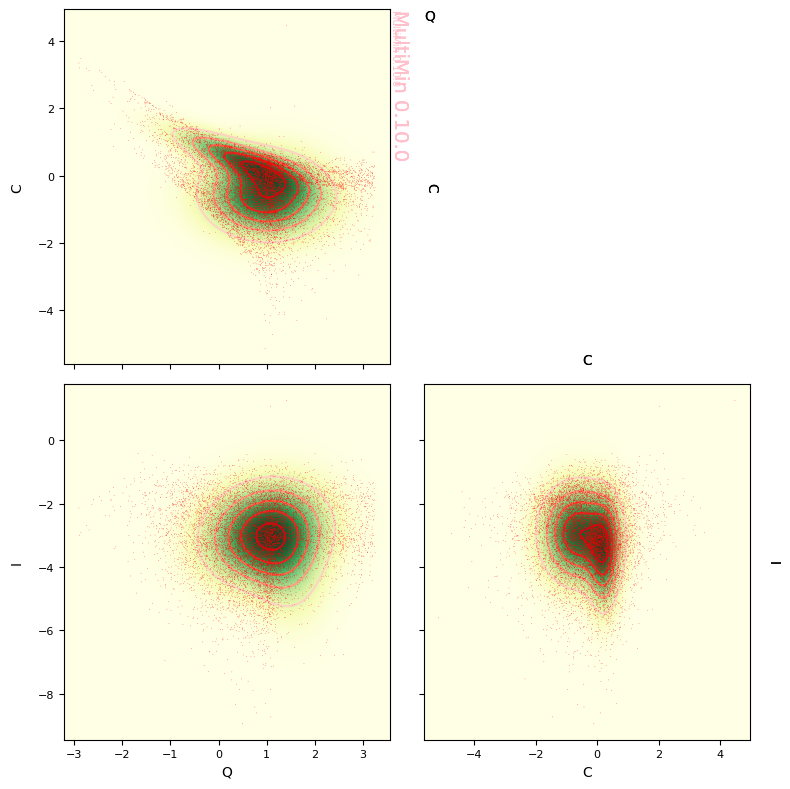

In [35]:
F=mn.FitMoG(data=udata, ngauss=2)

mn.Util.el_time(0)
F.fit_data(progress="tqdm")
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)

G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit-multiple-{F.prefix}.png")

Using two components improves the fit (lower $-\log\mathcal{L}/N$).

You can set bounds on parameters (e.g. means, weights) to avoid unphysical solutions:

Loading a FitMoG object.
Number of gaussians: 2
Number of variables: 3
Number of dimensions: 6
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.055958465015495


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 996.814 ms
-log(L)/N = 3.9043347379400344
Composition of ngauss = 2 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.2653618848438994, 0.7346381151561006]
    Number of variables: 3
    Averages (μ): [[0.4306931497158799, 0.48237275128112855, -3.4892795300116823], [0.9920533513889294, -0.5963990067493846, -2.9304380466747544]]
    Standard deviations (σ): [[0.8840613223010215, 0.586596040653865, 1.198448350649861], [0.8071903343614956, 0.7823095857460612, 0.9986488930891978]]
    Correlation coefficients (ρ): [[-0.8284341158629888, -0.3525327044608606, 0.3294777803892428], [-0.042785261429421406, 0.12272082691329667, -0.016922301376723903]]

    Covariant matrices (Σ): 
        [[[0.7815644215886307, -0.4296150562707895, -0.37350904677495883], [-0.4296150562707895, 0.3440949149107908, 0.23162454592094403], [-0.37350904677495883, 0.23162454592094403, 1.4362784491753724]], [[0.651556235886623, -0.027017726099272478, 0.0989252259215462], 

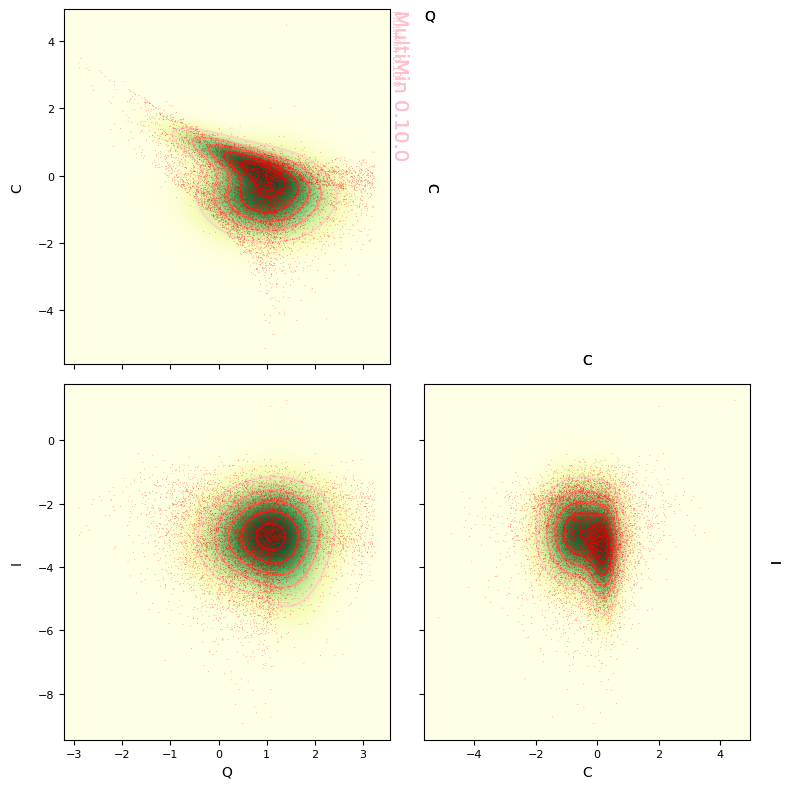

In [36]:
F=mn.FitMoG(data=udata, ngauss=2)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(udata,progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/{figprefix}_fit-multiple-bounds.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig("gallery/indepth_fit_2gauss_bounds_QCI.png")

Fitting with five Gaussians can capture more structure:

Loading a FitMoG object.
Number of gaussians: 5
Number of variables: 3
Number of dimensions: 15
Number of samples: 10000
Log-likelihood per point (-log L/N): 14.055958465015495


Minimizing: 0it [00:00, ?it/s]

Elapsed time since last call: 7.47604 s
-log(L)/N = 3.7341928210191466
Composition of ngauss = 5 gaussian multivariates of nvars = 3 random variables:
    Weights: [0.08686228058628981, 0.24771253909220448, 0.2734936521046515, 0.15032998774384726, 0.241601540473007]
    Number of variables: 3
    Averages (μ): [[0.21719503283486574, 0.7805036067252186, -3.7380536868327106], [0.9619196289994301, -0.7033844119124938, -2.294068698058596], [1.2807516449423106, 0.13022451573888347, -3.207119483825975], [-0.06141972745161285, -0.6836945058595633, -3.0830374427477794], [0.9977922424434233, -0.5550363200725187, -3.4779626801252355]]
    Standard deviations (σ): [[0.7418288360034905, 0.4692846801547465, 1.2510864277945626], [0.8022210093515226, 0.7030035442520548, 0.653392785228902], [0.8962829817628659, 0.3285244774666355, 0.8254873614659934], [0.7715382421793524, 1.3362494476678912, 1.17884856814759], [0.28316193962885505, 0.6408760815484321, 1.117969738059122]]
    Correlation coefficients (

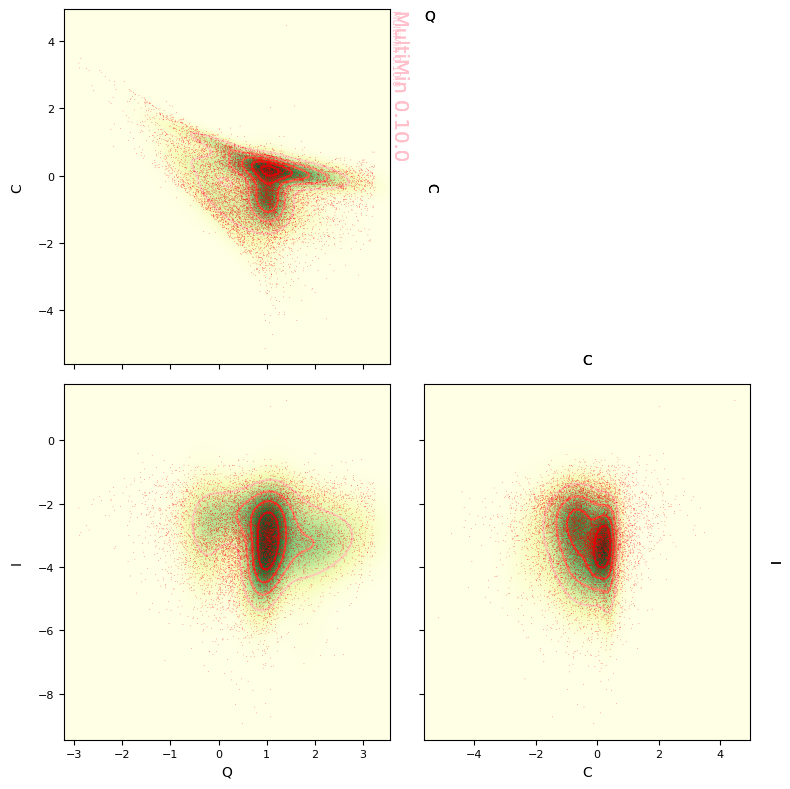

In [37]:
F=mn.FitMoG(data=udata, ngauss=5)
bounds=F.set_bounds(boundsm=((-2,4),(-4,3),(-7,0)),boundw=(0.1,0.9))

mn.Util.el_time(0)
F.fit_data(progress="tqdm",bounds=bounds)
mn.Util.el_time()
F.save_fit(f"gallery/fit-multiple-bound_mus.pkl",useprefix=False)

print(f"-log(L)/N = {F.solution.fun/len(udata)}")
print(F.mog)
G=F.plot_fit(figsize=4,
            properties=["Q","C","I"],
            pargs=dict(cmap='YlGn'),sargs=dict(s=0.2,edgecolor='None',color='r'),cargs=dict())
F.fig.savefig(f"gallery/{figprefix}_fit_5gauss_bound_mus_QCI.png")

As you can see the fitting parameter $-\log{\cal L}$ is improved with respect to previous fit. 

Verify the fit by generating a sample from the fitted MoG and comparing to the data:

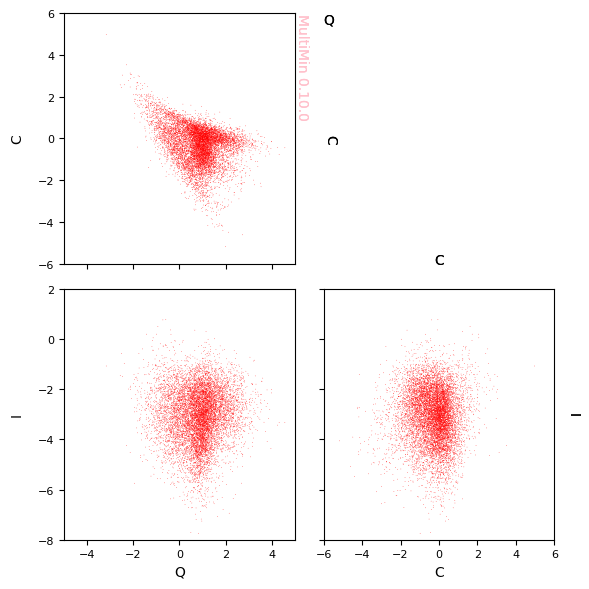

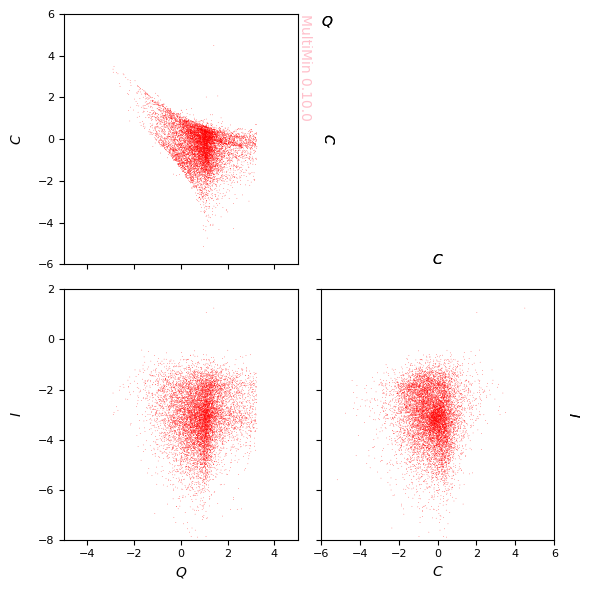

In [38]:
F.mog.plot_sample(N=len(F.data),
                  figsize=3,
                  properties=["Q","C","I"],ranges=[[-5,5],[-6,6],[-8,2]],
                  sargs=dict(s=0.2,edgecolor='None',color='r'))
G.fig.savefig(f"gallery/{figprefix}_sample_from_fit_20gauss_QCI.png")

properties=dict(
    Q=dict(label=r"$Q$",range=[-5,5]),
    C=dict(label=r"$C$",range=[-6,6]),
    I=dict(label=r"$I$",range=[-8,2]),
)
G=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
hist=G.sample_scatter(udata,**sargs)

We can also check the original distribution:

In [39]:
scales=[1.35,1.00,180.0]
usample = F.mog.rvs(len(udata))
rsample=np.zeros_like(usample)
for i in range(len(usample)):
    rsample[i] = mn.Util.t_if(usample[i], scales, mn.Util.u2f)

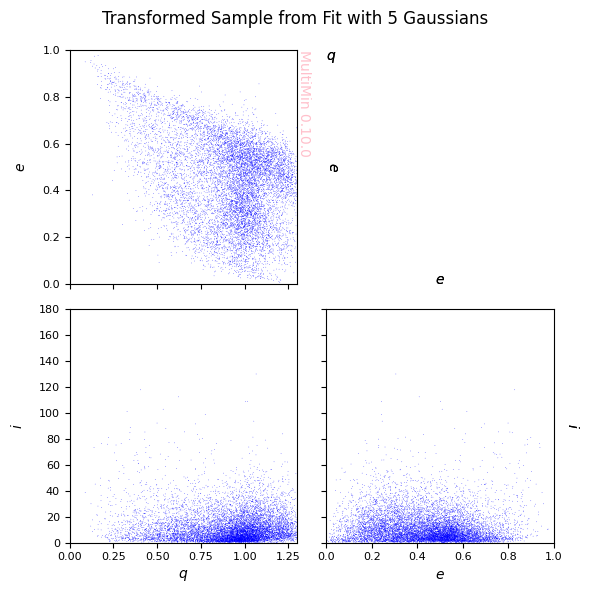

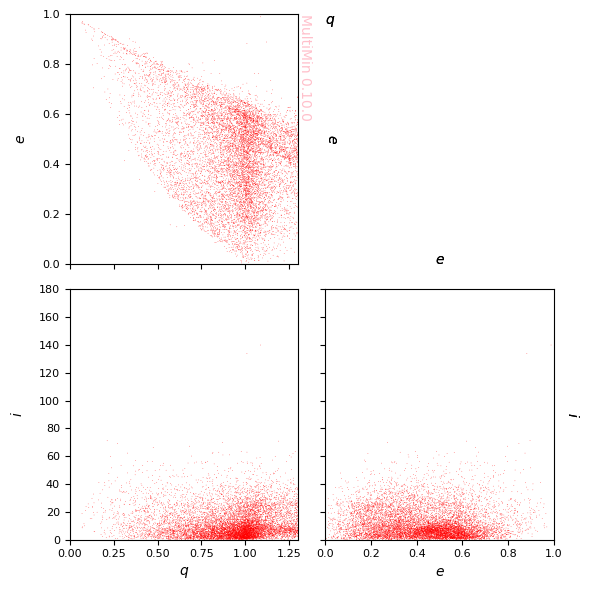

In [40]:
properties=dict(
    q=dict(label=r"$q$", range=[0.0, 1.3]),
    e=dict(label=r"$e$", range=[0.0, 1.0]),
    i=dict(label=r"$i$", range=[0.0, 180.0]),
)

Gt=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='b')
scatter_transformed=Gt.sample_scatter(rsample,**sargs)
Gt.fig.suptitle(f"Transformed Sample from Fit with {F.ngauss} Gaussians")
Gt.fig.tight_layout()
Gt.fig.savefig(f"gallery/{figprefix}_sample_from_fit_ngauss_qei.png")

Go=mn.MultiPlot(properties,figsize=3)
sargs=dict(s=0.2,edgecolor='None',color='r')
scatter_original=Go.sample_scatter(data_neas_qei,**sargs)

In [41]:
function, mog = F.mog.get_function(properties=properties)

from multimin import Util

def mog(X):

    mu1_q = 0.217195
    mu1_e = 0.780504
    mu1_i = -3.738054
    mu1 = [mu1_q, mu1_e, mu1_i]
    Sigma1 = [[0.55031, -0.323871, -0.432654], [-0.323871, 0.220228, 0.296764], [-0.432654, 0.296764, 1.565217]]
    n1 = Util.nmd(X, mu1, Sigma1)

    mu2_q = 0.96192
    mu2_e = -0.703384
    mu2_i = -2.294069
    mu2 = [mu2_q, mu2_e, mu2_i]
    Sigma2 = [[0.643559, -0.249327, 0.054103], [-0.249327, 0.494214, 0.010462], [0.054103, 0.010462, 0.426922]]
    n2 = Util.nmd(X, mu2, Sigma2)

    mu3_q = 1.280752
    mu3_e = 0.130225
    mu3_i = -3.207119
    mu3 = [mu3_q, mu3_e, mu3_i]
    Sigma3 = [[0.803323, -0.161529, 0.145132], [-0.161529, 0.107928, 0.034253], [0.145132, 0.034253, 0.681429]]
    n3 = Util.nmd(X, mu3, Sigma3)

    mu4_q = -0.06142
    mu4_e = -0.683695
    mu4_i = -3.083037
    mu4 = [mu4_q, mu4_e, mu4_i]
    Sigma4 = [[0.595271, -0.944712, -0.207345], [-0.944712, 1.785563, 0.387155], [-0.207345, 0.387155, 1.389684]]
    n4 = Util.nmd(X

---

**MultiMin** - Multivariate Gaussian fitting

© 2026 Jorge I. Zuluaga